In [1]:
import requests
import torch
import torch.nn as nn
import os
from torchvision import models
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision import transforms
from torch import optim
from matplotlib import pyplot as plt
import skimage
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
def filter_img(img: np.ndarray, eps: float = 0.01) -> np.ndarray:
    if len(img.shape) == 2:
        return False

    mg_diff_rg = np.abs(img[..., 0] - img[..., 1])
    img_diff_gb = np.abs(img[..., 1] - img[..., 2])
    img_diff_br = np.abs(img[..., 2] - img[..., 0])

    img_diff_max = np.maximum(np.maximum(mg_diff_rg, img_diff_gb), img_diff_br)
    is_skipped = img_diff_max.mean() > eps

    # if is_skipped:
    #     plt.imshow(img_diff_max)
    #     plt.show()

    return is_skipped

In [4]:
class TaskDataset(Dataset):
    def __init__(self, transform=None):

        self.ids = []
        self.imgs = []
        self.labels = []

        self.ids_new = []
        self.imgs_tensors = []
        self.labels_tensors = []

        self.transform = transform

    def compute_transform(self, should_skip: bool = True):
        self.ids_new = []
        self.imgs_tensors = []
        self.labels_tensors = []

        for id_, img, label in zip(self.ids, self.imgs, self.labels):
            if should_skip and filter_img(np.array(img).astype(np.float32) / 255.0):
                continue

            img = (transforms.functional.pil_to_tensor(img).float() / 255.0)
            if len(img.shape) == 2:
                img = torch.stack((img,)*3, axis=-1)
            elif img.shape[0] == 1:
                img = torch.cat((img,)*3, axis=0)
            self.imgs_tensors.append(img)

            label_tensor = torch.tensor(label)
            self.labels_tensors.append(label_tensor)

            self.ids_new.append(id_)

    def __getitem__(self, index) -> tuple[int, torch.Tensor, int]:
        id_ = self.ids_new[index]
        img = self.imgs_tensors[index]
        label = self.labels_tensors[index]

        if self.transform:
            img = self.transform(img)

        return id_, img, label

    def __len__(self):
        return len(self.ids_new)

In [40]:
test_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.Normalize([0.2980, 0.2962, 0.2987], [0.2886, 0.2875, 0.2889]),
])

train_transform = v2.Compose([
    v2.Resize((224, 224)),

    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomRotation(40),
    v2.RandomAffine(0, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=0.1),

    v2.RandomChoice([
        v2.GaussianBlur(3),
        v2.GaussianBlur(5),
        lambda x: x
    ], p=[0.3, 0.3, 0.4]),

    v2.ColorJitter(brightness=0.02, contrast=0.02, saturation=0.02, hue=0.01),

    v2.Normalize([0.2980, 0.2962, 0.2987], [0.2886, 0.2875, 0.2889]),
])

In [ ]:
all_dataset = torch.load('Train.pt', weights_only=False)
all_dataset.compute_transform()

train_size = int(0.9 * len(all_dataset))
valid_size = len(all_dataset) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(all_dataset, [train_size, valid_size])
train_dataset.transform = train_transform
valid_dataset.transform = test_transform

In [42]:
print(len(train_dataset), len(valid_dataset))

72988 18248


In [43]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=16, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=True, num_workers=16, pin_memory=True)

In [44]:
# labels = {}

# for _, img, label in tqdm(train_dataset):
#     label_value = int(label.item())
#     if label_value not in labels:
#         labels[label_value] = 1
#     else:
#         labels[label_value] += 1

labels = {
    8: 31802,
    2: 23356,
    5: 14886,
    4: 7036,
    1: 9171,
    7: 409,
    9: 4706,
    3: 3568,
    6: 4642,
    0: 424
}

In [45]:
labels

{8: 31802,
 2: 23356,
 5: 14886,
 4: 7036,
 1: 9171,
 7: 409,
 9: 4706,
 3: 3568,
 6: 4642,
 0: 424}

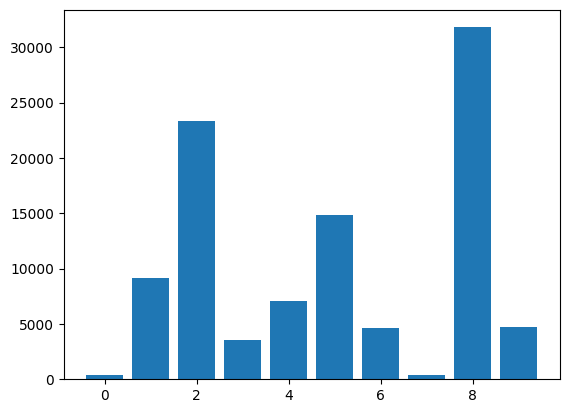

In [46]:
plt.bar(labels.keys(), labels.values())
plt.show()

In [54]:
model = models.resnet50(pretrained=True).to(device)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(2048, 10).to(device)

In [55]:
total_count = sum(labels.values())
class_weights = [total_count / labels[label] for label in sorted(labels.keys())]
class_weights = torch.tensor(class_weights).to(device)
print(class_weights)

tensor([235.8491,  10.9039,   4.2816,  28.0269,  14.2126,   6.7177,  21.5424,
        244.4988,   3.1445,  21.2495], device='cuda:0')


In [56]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [57]:
def get_some_worst_prediction_images(model: nn.Module, dataloader: DataLoader, limit_proba: float = 0.01) -> list[tuple[torch.Tensor, float]]:
    worst_images_return = []

    for _, imgs, labels in dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        labels_pred_proba = torch.softmax(outputs, dim=1)
        real_labels_proba = labels_pred_proba[torch.arange(labels.size(0)), labels]

        is_worst = real_labels_proba < limit_proba
        worst_images = imgs[is_worst]

        for i in range(worst_images.size(0)):
            worst_images_return.append((worst_images[i], real_labels_proba[i].item()))

    return worst_images_return

In [77]:
def fgsm_attack(model, images, labels, epsilon, criterion, min_val, max_val):
    images.requires_grad = True
    outputs = model(images)
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()
    
    adv_images = images + epsilon * images.grad.sign()
    
    adv_images = torch.clamp(adv_images, min=min_val, max=max_val)
    return adv_images.detach()

def pgd_attack(model, images, labels, epsilon, num_steps, step_size, criterion, min_val, max_val):
    adv_images = images.clone().detach()
    adv_images.requires_grad_()
    for _ in range(num_steps):
        outputs = model(adv_images)
        loss = criterion(outputs, labels)
        model.zero_grad()
        loss.backward()
        adv_images = adv_images + step_size * adv_images.grad.sign()
        
        perturbation = torch.clamp(adv_images - images, min=-epsilon, max=epsilon)
        adv_images = images + perturbation
        
        adv_images = torch.clamp(adv_images, min=min_val, max=max_val)
        
        adv_images = adv_images.detach()
        adv_images.requires_grad_()
    return adv_images.detach()

In [70]:
mean = [0.2980, 0.2962, 0.2987]
std = [0.2886, 0.2875, 0.2889]

mean_tensor = torch.tensor(mean).view(3, 1, 1).to(device)
std_tensor = torch.tensor(std).view(3, 1, 1).to(device)
min_val = ((0 - mean_tensor) / std_tensor)
max_val = ((1 - mean_tensor) / std_tensor)

print(min_val, max_val)

tensor([[[-1.0326]],

        [[-1.0303]],

        [[-1.0339]]], device='cuda:0') tensor([[[2.4324]],

        [[2.4480]],

        [[2.4275]]], device='cuda:0')


In [80]:
def train(model: nn.Module, optimizer: optim.Optimizer, criterion, train_dataloader: DataLoader,
          epochs: int, val_dataloader: DataLoader | None = None, epsilon: float = 0.03, alpha: float = 0.5,
          num_steps: int = 5, step_size: float = 0.01,
          alpha_clean: float = 0.33, alpha_fgsm: float = 0.33, alpha_pgd: float = 0.34):
    loss_history = []
    accuracy_history = []
    
    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        total = 0

        model.train()
        for id_, img, label in tqdm(train_dataloader):
            img = img.to(device)
            label = label.to(device)

            # ###

            # img.requires_grad = True

            # optimizer.zero_grad()
            # outputs = model(img)

            # class_loss = criterion(outputs, label)
            # class_img_grad = torch.autograd.grad(class_loss, img, retain_graph=True)[0]
            # new_img = img + epsilon * torch.sign(class_img_grad)
            # new_img = torch.clamp(new_img, 0, 1)

            # outputs_new = model(new_img)
            # loss = alpha * criterion(outputs, label) + (1 - alpha) * criterion(outputs_new, label)

            # ###

            optimizer.zero_grad()

            outputs_clean = model(img)
            loss_clean = criterion(outputs_clean, label)
            
            adv_imgs_fgsm = fgsm_attack(model, img, label, epsilon, criterion, min_val, max_val)
            outputs_fgsm = model(adv_imgs_fgsm)
            loss_fgsm = criterion(outputs_fgsm, label)

            # Generate adversarial examples with PGD and compute loss
            adv_imgs_pgd = pgd_attack(model, img, label, epsilon, num_steps, step_size, criterion, min_val, max_val)
            outputs_pgd = model(adv_imgs_pgd)
            loss_pgd = criterion(outputs_pgd, label)

            loss = alpha_clean * loss_clean + alpha_fgsm * loss_fgsm + alpha_pgd * loss_pgd

            # ###

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = torch.argmax(outputs_clean, dim=1)
            total_correct += (predicted == label).sum().item()

            total += len(label)

        avg_loss = total_loss / total
        accuracy = total_correct / total

        if val_dataloader is not None:
            model.eval()
            total_val_loss = 0
            total_val_correct = 0
            total_val = 0

            with torch.no_grad():
                for _, img, label in val_dataloader:
                    img = img.to(device)
                    label = label.to(device)

                    outputs = model(img)
                    loss = criterion(outputs, label)

                    total_val_loss += loss.item()
                    predicted = torch.argmax(outputs, dim=1)
                    total_val_correct += (predicted == label).sum().item()

                    total_val += len(label)

            avg_val_loss = total_val_loss / total_val
            val_accuracy = total_val_correct / total_val
            print(f'Epoch: {epoch} Loss: {avg_loss} Accuracy: {accuracy} Val Loss: {avg_val_loss} Val Accuracy: {val_accuracy}')
        else:
            print(f'Epoch: {epoch} Loss: {avg_loss} Accuracy: {accuracy}')
            
        loss_history.append(avg_loss)
        accuracy_history.append(accuracy)

    return loss_history, accuracy_history

In [81]:
loss_history, acc_history = train(model, optimizer, criterion, train_dataloader, 4, valid_dataloader)

for param in model.parameters():
    param.requires_grad = True

# for param in model.layer4.parameters():
#     param.requires_grad = True

loss_history_new, acc_history_new = train(model, optimizer, criterion, train_dataloader, 20, valid_dataloader)
loss_history += loss_history_new
acc_history += acc_history_new

# for param in model.layer3.parameters():
#     param.requires_grad = True

loss_history_new, acc_history_new = train(model, optimizer, criterion, train_dataloader, 30, valid_dataloader)
loss_history += loss_history_new
acc_history += acc_history_new

# for param in model.layer2.parameters():
#     param.requires_grad = True

loss_history_new, acc_history_new = train(model, optimizer, criterion, train_dataloader, 40, valid_dataloader)
loss_history += loss_history_new
acc_history += acc_history_new

100%|█████████████████████████████████████████████████████████████████████████████████| 571/571 [02:16<00:00,  4.18it/s]


Epoch: 0 Loss: 0.0578451462691468 Accuracy: 0.9912451361867705 Val Loss: 0.029688620661393116 Val Accuracy: 0.5562801402893468


100%|█████████████████████████████████████████████████████████████████████████████████| 571/571 [02:15<00:00,  4.21it/s]


Epoch: 1 Loss: 0.057589342811437294 Accuracy: 0.9917520688332329 Val Loss: 0.027271016275919303 Val Accuracy: 0.5611025865848313


100%|█████████████████████████████████████████████████████████████████████████████████| 571/571 [02:16<00:00,  4.18it/s]


Epoch: 2 Loss: 0.05758563279386951 Accuracy: 0.9916561626568751 Val Loss: 0.03213879127661318 Val Accuracy: 0.571733888645331


100%|█████████████████████████████████████████████████████████████████████████████████| 571/571 [02:15<00:00,  4.20it/s]


Epoch: 3 Loss: 0.057710527034434855 Accuracy: 0.9912999397161177 Val Loss: 0.0306540444486761 Val Accuracy: 0.5518960982025427


  7%|█████▌                                                                            | 39/571 [00:11<02:41,  3.29it/s]


KeyboardInterrupt: 

In [ ]:
worst_images = get_some_worst_prediction_images(model, valid_dataloader, 0.1)
print(len(worst_images))

3806


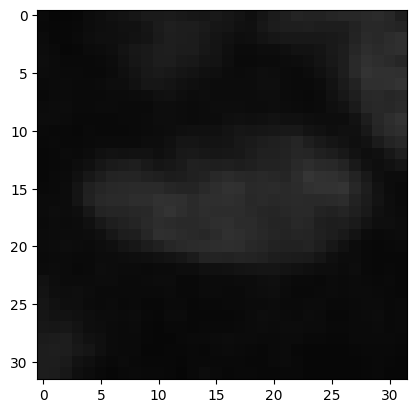

In [ ]:
plt.imshow(worst_images[21][0].cpu().permute(1, 2, 0))
plt.show()

In [ ]:
torch.save(model.state_dict(), 'model_weights_2.pt')

In [ ]:
# os.makedirs("out/models", exist_ok=True)

#### SUBMISSION ####

# Create a dummy model
# model = models.resnet50(weights=None)
# model.fc = nn.Linear(model.fc.weight.shape[1], 10)
# torch.save(model.state_dict(), "out/models/dummy_submission.pt")

#### Tests ####
# (these are being ran on the eval endpoint for every submission)

allowed_models = {
    "resnet18": models.resnet18,
    "resnet34": models.resnet34,
    "resnet50": models.resnet50,
}
with open("model_weights_2.pt", "rb") as f:
    try:
        model: torch.nn.Module = allowed_models["resnet50"](weights=None)
        model.fc = torch.nn.Linear(model.fc.weight.shape[1], 10)
    except Exception as e:
        raise Exception(
            f"Invalid model class, {e=}, only {allowed_models.keys()} are allowed",
        )
    try:
        state_dict = torch.load(f, map_location=torch.device("cpu"))
        model.load_state_dict(state_dict, strict=True)
        model.eval()
        out = model(torch.randn(1, 3, 32, 32))
    except Exception as e:
        raise Exception(f"Invalid model, {e=}")

    assert out.shape == (1, 10), "Invalid output shape"


# Send the model to the server
response = requests.post(
    "http://149.156.182.9:6060/task-3/submit",
    headers={
        "token": "i2SLZ1KbTzJeGkfPTWxE2Y53W9D0R5",
        "model-name": "resnet50"
    },
    files={
        "model_state_dict": open("model_weights_2.pt", "rb")
    }
)

# Should be 400, the clean accuracy is too low
print(response.status_code, response.text)

200 clean: 0.5733333333333334 fgsm: 0.14433333333333334 pgd: 0.005666666666666667
